# Mediationsprototype 2.1 
 Version 2 Teil 1 Anonymisierung Vergleich



daten /ppm werden nicht im Bitbucket gehalten (Privacy)
anonymizierte Daten (nach Kontrolle in /npm verschoben )


In [208]:
# %pip install xxx

## Vorbereiten der rtf
Die Quellscripte werden von technischen Steuerzeichen befreite und als UTF8 im txt Format vorbereitet.
Es wird für jede Sitzung eine Datei erstellt. _S1.txt .. _S6.txt  

In [209]:
import os
import re
from striprtf.striprtf import rtf_to_text

# Definiere die Verzeichnisse und Dateinamen
input_dir = r'ppm\F5'  # Achte darauf, dass dieser Pfad existiert und korrekt ist

output_dir = r'ppm\F5'
output_file_path = os.path.join(output_dir, '_S')

# Überprüfen, ob das Zielverzeichnis existiert, und es ggf. erstellen
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Liste der RTF-Dateinamen ausgeben
print(f"Suche nach RTF-Dateien in: {input_dir}")

# RTF-Dateien finden und deren Inhalt bereinigen
rtf_files = [f'S{i}.rtf' for i in range(1, 7)]  # Liste mit Dateinamen von S1.rtf bis S6.rtf
extracted_texts = []  # Sammlung für bereinigte Texte

i = 1
for rtf_file in rtf_files:
    file_path = os.path.join(input_dir, rtf_file)
    if os.path.isfile(file_path):
        print(f"Verarbeite Datei: {file_path}")
        with open(file_path, 'r', encoding='utf-8') as file:
            rtf_content = file.read()
            text = rtf_to_text(rtf_content)  # RTF-Steuerdaten entfernen
            cleaned_text = '\n'.join(filter(lambda x: x.strip(), text.splitlines()))
            #extracted_texts.append(cleaned_text)
            with open(f"{output_file_path}{i}.txt" , 'w', encoding='utf-8') as output_file:
                output_file.write(''.join(cleaned_text))
                print(f"Die Inhalte wurden erfolgreich in '{output_file_path}{i}' gespeichert.")
    else:
        print(f"Datei nicht gefunden: {file_path}")
    i += 1


# Bereinigte RTF-Inhalte in eine Ausgabedatei schreiben
if extracted_texts:
    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        output_file.write('\n'.join(extracted_texts))
    print(f"Die Inhalte wurden erfolgreich in '{output_file_path}'.txt gespeichert.")
else:
    print("Keine RTF-Inhalte zum Speichern gefunden.")

Suche nach RTF-Dateien in: ppm\F5
Verarbeite Datei: ppm\F5\S1.rtf
Die Inhalte wurden erfolgreich in 'ppm\F5\_S1' gespeichert.
Verarbeite Datei: ppm\F5\S2.rtf
Die Inhalte wurden erfolgreich in 'ppm\F5\_S2' gespeichert.
Verarbeite Datei: ppm\F5\S3.rtf
Die Inhalte wurden erfolgreich in 'ppm\F5\_S3' gespeichert.
Verarbeite Datei: ppm\F5\S4.rtf
Die Inhalte wurden erfolgreich in 'ppm\F5\_S4' gespeichert.
Verarbeite Datei: ppm\F5\S5.rtf
Die Inhalte wurden erfolgreich in 'ppm\F5\_S5' gespeichert.
Verarbeite Datei: ppm\F5\S6.rtf
Die Inhalte wurden erfolgreich in 'ppm\F5\_S6' gespeichert.
Keine RTF-Inhalte zum Speichern gefunden.


## PII Analyse und  Anonymisierung
Die Analyse erfolt mit den Frameworks Spacy, Transformer und MS Presidio mit verschiedenen Identifikationsmethoden. Zudem werden Manuell Identifizierte Eigennamen und Orte als Liste hinzugefügt, da Testreihen bestimmte Eigenamen unzuverlässig erkannt haben. Hier ist Finetuning und Training der Modelle möglich, allerdings nicht Fokus dieser Untersuchung. 

In [287]:
import os
text_list = []
input_dir = r'ppm\F5'

for i in range(1, 2):  # Annahme: _S1.txt bis _S6.txt
    filename = f'_S{i}.txt'
    input_file_path = os.path.join(input_dir, filename)
    print(f"Transkript : {input_file_path} geladen")
    with open(input_file_path, 'r', encoding='utf-8') as file:
        text = file.read()
        text_list.append(text)

Transkript : ppm\F5\_S1.txt geladen


### Konfiguration der Analyse NER

In [288]:
import spacy
from presidio_analyzer import AnalyzerEngine, RecognizerRegistry, PatternRecognizer
from presidio_analyzer.nlp_engine import NlpEngineProvider
from transformers import pipeline

from presidio_anonymizer import OperatorConfig
from presidio_anonymizer.operators import Operator, OperatorType
from typing import Dict


# SpaCy-Model laden
SPACY_MODEL = "de_core_news_lg"
nlp = spacy.load(SPACY_MODEL)


# Transformer-Model laden
TRANSFORMER_MODEL = "domischwimmbeck/bert-base-german-cased-fine-tuned-ner"
nlp_transformer = pipeline("ner", model=TRANSFORMER_MODEL) 

# Presidio-Konfiguration
PRESIDIO_ENTITIES = ["PERSON", "LOCATION", "ORGANIZATION", "EMAIL_ADDRESS", "IBAN_CODE", "PHONE_NUMBER"]

configuration = {
    "nlp_engine_name": "spacy", 
    "models": [{"lang_code": "de", "model_name": "de_core_news_lg"
                , "transformers":"Isotonic/distilbert-base-german-cased_finetuned_ai4privacy_v2" 
                },
               {"lang_code": "en", "model_name": "en_core_web_lg"
                , "transformers":"Isotonic/distilbert-base-german-cased_finetuned_ai4privacy_v2"
                }]
    }
recognizer_config = {
    "PERSON_NAME": {  # Erkennt Personennamen
        "min_length": 4  # Setzt minimale Länge auf 4
    },
    "LOCATION": {     # Erkennt Orte
        "min_length": 3  # Setzt minimale Länge auf 3
    }
}

# Get known values as a deny-list --> Bekannte Namen und Ort der Mediationen hier 
known_names_list = ["Ines", "Abraham", "Theodore", "Bill", "Barack", "Donald", "Joe"]
known_locations_list = ["Karlsruhe","Karlsruher"]

#Whitelist --> alles was nicht als PII erkannt werden soll 
allow_list = ["Stadt","B1","B2"]

# Create a PatternRecognizer for the deny list  
deny_list_recognizer_loc = PatternRecognizer(supported_entity="LOCATION", supported_language= "de", deny_list=known_locations_list)
deny_list_recognizer_per = PatternRecognizer(supported_entity="PERSON", supported_language= "de", deny_list=known_names_list)

registry = RecognizerRegistry()
registry.load_predefined_recognizers(languages=["de","en"])
registry.add_recognizer(deny_list_recognizer_loc)
registry.add_recognizer(deny_list_recognizer_per)

provider = NlpEngineProvider(nlp_configuration=configuration)
analyzer = AnalyzerEngine(registry=registry, supported_languages=["de"], nlp_engine=provider.create_engine())
#print(registry.list_recognizers())
# List loaded recognizers
#for recognizer in analyzer.registry.recognizers:
    #print(f"Recognizer Name: {recognizer.name}")

### Anomizer laden  

In [284]:
class InstanceCounterAnonymizer(Operator):
    """
    Anonymizer which replaces the entity value
    with an instance counter per entity.
    """

    REPLACING_FORMAT = "<{entity_type}_{index}>"

    def operate(self, text: str, params: Dict = None) -> str:
        """Anonymize the input text."""

        entity_type: str = params["entity_type"]

        # entity_mapping is a dict of dicts containing mappings per entity type
        entity_mapping: Dict[Dict:str] = params["entity_mapping"]

        entity_mapping_for_type = entity_mapping.get(entity_type)
        if not entity_mapping_for_type:
            new_text = self.REPLACING_FORMAT.format(
                entity_type=entity_type, index=0
            )
            entity_mapping[entity_type] = {}

        else:
            if text in entity_mapping_for_type:
                return entity_mapping_for_type[text]

            previous_index = self._get_last_index(entity_mapping_for_type)
            new_text = self.REPLACING_FORMAT.format(
                entity_type=entity_type, index=previous_index + 1
            )

        entity_mapping[entity_type][text] = new_text
        return new_text

    @staticmethod
    def _get_last_index(entity_mapping_for_type: Dict) -> int:
        """Get the last index for a given entity type."""

        def get_index(value: str) -> int:
            return int(value.split("_")[-1][:-1])

        indices = [get_index(v) for v in entity_mapping_for_type.values()]
        return max(indices)

    def validate(self, params: Dict = None) -> None:
        """Validate operator parameters."""

        if "entity_mapping" not in params:
            raise ValueError("An input Dict called `entity_mapping` is required.")
        if "entity_type" not in params:
            raise ValueError("An entity_type param is required.")

    def operator_name(self) -> str:
        return "entity_counter"

    def operator_type(self) -> OperatorType:
        return OperatorType.Anonymize

### Analyse und Anomize Funktionen

In [289]:
# Anonymisierungsfunktionen
def anonymize_text_spacy(doc):
    entity_count = {}
    anonymized_text = []
    for token in doc:
        entity_type = token.ent_type_
        if entity_type in ["PER", "ORG", "LOC"] and len(token.text) > 3:
            if entity_type not in entity_count:
                entity_count[entity_type] = 1
            else:
                entity_count[entity_type] += 1 
            unique_label = f"<{entity_type} {entity_count[entity_type]}>" 
            anonymized_text.append(unique_label)
        else:
            anonymized_text.append(token.text)
    return " ".join(anonymized_text)

def anonymize_text_transformer(anonymized_text, entities_transformer):
    entity_count = {}  
    offset = 0
    result_text = ""
    for entity in entities_transformer:
        if entity["score"] >= 0.6 and len(entity["word"]) > 3:
            entity_type = entity['entity']
            if entity_type not in entity_count:
                entity_count[entity_type] = 1
            else:
                entity_count[entity_type] += 1            
            unique_label = f"<{entity_type} {entity_count[entity_type]}>" 
            start_index = anonymized_text.find(entity['word'], offset)

            if start_index != -1:
                result_text += anonymized_text[offset:start_index]
                result_text += unique_label
                offset = start_index + len(unique_label)  # Update offset based on label length
    result_text += anonymized_text[offset:]
    return result_text

def anonymize_text_with_presidio(text, analyzer_result):
    anonymized_text = text
    global entity_occurrences
    current_offset = 0
    for result in analyzer_result:
        start = result.start + current_offset
        end = result.end + current_offset
        entity_type = result.entity_type
        word = text[start:end]

        if entity_type not in entity_occurrences:
            entity_occurrences[entity_type] = {}

        if word not in entity_occurrences[entity_type]:
            entity_occurrences[entity_type][word] = 1
        else:
            entity_occurrences[entity_type][word] += 1

        unique_label = f"<{entity_type} {entity_occurrences[entity_type][word]}>"     
        anonymized_text = anonymized_text[:start] + unique_label + anonymized_text[end:]
        current_offset = len(anonymized_text) - len(text) 
        
    return anonymized_text

def anonymize_text_with_presidio2(text, analyzer_result):
    anonymizer_engine = AnonymizerEngine()
    anonymizer_engine.add_anonymizer(InstanceCounterAnonymizer)
    entity_mapping = {}
    anonymized_result = anonymizer_engine.anonymize(text=text, analyzer_results= analyzer_result,
                                          operators={ "DEFAULT": OperatorConfig(
                                                "entity_counter", {"entity_mapping": entity_mapping})})
    anonymized_text = anonymized_result.text
    return anonymized_text




### Ausführen der Analysen und Anonymisierungen

In [293]:
# Create Anonymizer engine and add the custom anonymizer


# Create a mapping between entity types and counters
entity_mapping = dict()

#text_list = ["B2:Bernd wohnt in Berlin. Max Mustermann arbeitet bei Bosch und wohnt in (Karlsruhe?). in der Auenstrasse 3. Max hat aber auch Verwandte in Berlin.  #00:03:27-7#"]
#text_list.append(text)
# run_spacy
anonymized_text_spacy_list = []
anonymized_text_transformer_list = []
anonymized_text_presidio_list = []

entity_occurrences = {} 

for text in text_list:
    #print(f"\n{text[:200]}")
    
    #spacy
    #analyser_spacy = nlp(text)
    #entities_spacy = [(ent.text, ent.label_) for ent in analyser_spacy.ents]
    #print(f"Spacy \n{entities_spacy}")
    anonymized_text_spacy_list.append(anonymize_text_spacy(nlp(text))) 
    #print(anonymized_text_spacy_list[:200])

    #transformer (pesidio preferd)  
    anonymized_text_transformer_list.append(anonymize_text_transformer(text, nlp_transformer(text)))
    #print(anonymized_text_transformer_list[:200])
    
    #presidio
    analyser_pres = analyzer.analyze(text=text, language="de", entities=PRESIDIO_ENTITIES, score_threshold=0.5,return_decision_process = True, allow_list = allow_list)
    #print(f"Presidio \n{analyser_pres}")
    
    anonymized_text_presidio_list.append(anonymize_text_with_presidio2(text, analyser_pres))
    #print(anonymized_text_presidio_list[:200])
    #for results in analyser_pres:
        #print(f"Finding {results}  mit {results.analysis_explanation}")


Finding type: LOCATION, start: 2937, end: 2946, score: 1.0  mit {'recognizer': 'PatternRecognizer', 'pattern_name': 'deny_list', 'pattern': '(?:^|(?<=\\W))(Karlsruhe|Karlsruher)(?:(?=\\W)|$)', 'original_score': 1.0, 'score': 1.0, 'textual_explanation': None, 'score_context_improvement': 0, 'supportive_context_word': '', 'validation_result': None, 'regex_flags': regex.I|M|S}
Finding type: PERSON, start: 21696, end: 21700, score: 1.0  mit {'recognizer': 'PatternRecognizer', 'pattern_name': 'deny_list', 'pattern': '(?:^|(?<=\\W))(Ines|Abraham|Theodore|Bill|Barack|Donald|Joe)(?:(?=\\W)|$)', 'original_score': 1.0, 'score': 1.0, 'textual_explanation': None, 'score_context_improvement': 0, 'supportive_context_word': '', 'validation_result': None, 'regex_flags': regex.I|M|S}
Finding type: LOCATION, start: 98558, end: 98567, score: 1.0  mit {'recognizer': 'PatternRecognizer', 'pattern_name': 'deny_list', 'pattern': '(?:^|(?<=\\W))(Karlsruhe|Karlsruher)(?:(?=\\W)|$)', 'original_score': 1.0, 'sco

In [ ]:
class InstanceCounterAnonymizer(Operator):
    """
    Anonymizer which replaces the entity value
    with an instance counter per entity.
    """

    REPLACING_FORMAT = "<{entity_type}_{index}>"

    def operate(self, text: str, params: Dict = None) -> str:
        """Anonymize the input text."""

        entity_type: str = params["entity_type"]

        # entity_mapping is a dict of dicts containing mappings per entity type
        entity_mapping: Dict[Dict:str] = params["entity_mapping"]

        entity_mapping_for_type = entity_mapping.get(entity_type)
        if not entity_mapping_for_type:
            new_text = self.REPLACING_FORMAT.format(
                entity_type=entity_type, index=0
            )
            entity_mapping[entity_type] = {}

        else:
            if text in entity_mapping_for_type:
                return entity_mapping_for_type[text]

            previous_index = self._get_last_index(entity_mapping_for_type)
            new_text = self.REPLACING_FORMAT.format(
                entity_type=entity_type, index=previous_index + 1
            )

        entity_mapping[entity_type][text] = new_text
        return new_text

    @staticmethod
    def _get_last_index(entity_mapping_for_type: Dict) -> int:
        """Get the last index for a given entity type."""

        def get_index(value: str) -> int:
            return int(value.split("_")[-1][:-1])

        indices = [get_index(v) for v in entity_mapping_for_type.values()]
        return max(indices)

    def validate(self, params: Dict = None) -> None:
        """Validate operator parameters."""

        if "entity_mapping" not in params:
            raise ValueError("An input Dict called `entity_mapping` is required.")
        if "entity_type" not in params:
            raise ValueError("An entity_type param is required.")

    def operator_name(self) -> str:
        return "entity_counter"

    def operator_type(self) -> OperatorType:
        return OperatorType.Anonymize

In [ ]:
class InstanceCounterAnonymizer(Operator):
    """
    Anonymizer which replaces the entity value
    with an instance counter per entity.
    """

    REPLACING_FORMAT = "<{entity_type}_{index}>"

    def operate(self, text: str, params: Dict = None) -> str:
        """Anonymize the input text."""

        entity_type: str = params["entity_type"]

        # entity_mapping is a dict of dicts containing mappings per entity type
        entity_mapping: Dict[Dict:str] = params["entity_mapping"]

        entity_mapping_for_type = entity_mapping.get(entity_type)
        if not entity_mapping_for_type:
            new_text = self.REPLACING_FORMAT.format(
                entity_type=entity_type, index=0
            )
            entity_mapping[entity_type] = {}

        else:
            if text in entity_mapping_for_type:
                return entity_mapping_for_type[text]

            previous_index = self._get_last_index(entity_mapping_for_type)
            new_text = self.REPLACING_FORMAT.format(
                entity_type=entity_type, index=previous_index + 1
            )

        entity_mapping[entity_type][text] = new_text
        return new_text

    @staticmethod
    def _get_last_index(entity_mapping_for_type: Dict) -> int:
        """Get the last index for a given entity type."""

        def get_index(value: str) -> int:
            return int(value.split("_")[-1][:-1])

        indices = [get_index(v) for v in entity_mapping_for_type.values()]
        return max(indices)

    def validate(self, params: Dict = None) -> None:
        """Validate operator parameters."""

        if "entity_mapping" not in params:
            raise ValueError("An input Dict called `entity_mapping` is required.")
        if "entity_type" not in params:
            raise ValueError("An entity_type param is required.")

    def operator_name(self) -> str:
        return "entity_counter"

    def operator_type(self) -> OperatorType:
        return OperatorType.Anonymize

### Speichern der anonymisierten Transkriptionen

In [278]:
for index,anon_text in enumerate(anonymized_text_spacy_list):
    print(f"\nAnonymisierter Text (SpaCy){index+1}:\n{anon_text[:200]}")
for index,anon_text in enumerate(anonymized_text_transformer_list):
    print(f"\nAnonymisierter Text (Transformer){index+1}:\n{anon_text[:200]}")
for index,anon_text in enumerate(anonymized_text_presidio_list):
    print(f"\nAnonymisierter Text (Presidio){index+1}:\n{anon_text[:200]}")


Anonymisierter Text (SpaCy)1:
KA86 - 1 
 I1 : Kommt noch was an ? Ja , jetzt kommt was an . Gucken wir mal , ob das besser ist . ( Ton geschnitten ) Jetzt testen wir das Verhalten beim Zuklappen . Ich klappe zu , eins , zwei , ihr

Anonymisierter Text (Transformer)1:
KA86-1
I1: Kommt noch was an? Ja, jetzt kommt was an. Gucken wir mal, ob das besser ist. (Ton geschnitten) Jetzt testen wir das Verhalten beim Zuklappen. Ich klappe zu, eins, zwei, ihr auch. Eins, zwe

Anonymisierter Text (Presidio)1:
KA86-1
I1: Kommt noch was an? Ja, jetzt kommt was an. Gucken wir mal, ob das besser ist. (Ton geschnitten) Jetzt testen wir das Verhalten beim Zuklappen. Ich klappe zu, eins, zwei, ihr auch. Eins, zwe


In [292]:
for index,anon_text in enumerate(anonymized_text_spacy_list):
    anon_output_file_path = os.path.join(output_dir, f'anon_Spacy_{index+1}.txt')        
    with open(anon_output_file_path, 'w', encoding='utf-8') as file:    
        file.write(anon_text)
     
for index,anon_text in enumerate(anonymized_text_transformer_list):
    anon_output_file_path = os.path.join(output_dir, f'anon_Transformer_{index+1}.txt')        
    with open(anon_output_file_path, 'w', encoding='utf-8') as file:    
        file.write(anon_text)

for index,anon_text in enumerate(anonymized_text_presidio_list):
    anon_output_file_path = os.path.join(output_dir, f'anon_Presidio_old_{index+1}.txt')        
    with open(anon_output_file_path, 'w', encoding='utf-8') as file:    
        file.write(anon_text)
print("Anonymisierte Transkriptionen gespeichert")    

Anonymisierte Transkriptionen gespeichert


In [ ]:
class InstanceCounterAnonymizer(Operator):
    """
    Anonymizer which replaces the entity value
    with an instance counter per entity.
    """

    REPLACING_FORMAT = "<{entity_type}_{index}>"

    def operate(self, text: str, params: Dict = None) -> str:
        """Anonymize the input text."""

        entity_type: str = params["entity_type"]

        # entity_mapping is a dict of dicts containing mappings per entity type
        entity_mapping: Dict[Dict:str] = params["entity_mapping"]

        entity_mapping_for_type = entity_mapping.get(entity_type)
        if not entity_mapping_for_type:
            new_text = self.REPLACING_FORMAT.format(
                entity_type=entity_type, index=0
            )
            entity_mapping[entity_type] = {}

        else:
            if text in entity_mapping_for_type:
                return entity_mapping_for_type[text]

            previous_index = self._get_last_index(entity_mapping_for_type)
            new_text = self.REPLACING_FORMAT.format(
                entity_type=entity_type, index=previous_index + 1
            )

        entity_mapping[entity_type][text] = new_text
        return new_text

    @staticmethod
    def _get_last_index(entity_mapping_for_type: Dict) -> int:
        """Get the last index for a given entity type."""

        def get_index(value: str) -> int:
            return int(value.split("_")[-1][:-1])

        indices = [get_index(v) for v in entity_mapping_for_type.values()]
        return max(indices)

    def validate(self, params: Dict = None) -> None:
        """Validate operator parameters."""

        if "entity_mapping" not in params:
            raise ValueError("An input Dict called `entity_mapping` is required.")
        if "entity_type" not in params:
            raise ValueError("An entity_type param is required.")

    def operator_name(self) -> str:
        return "entity_counter"

    def operator_type(self) -> OperatorType:
        return OperatorType.Anonymize

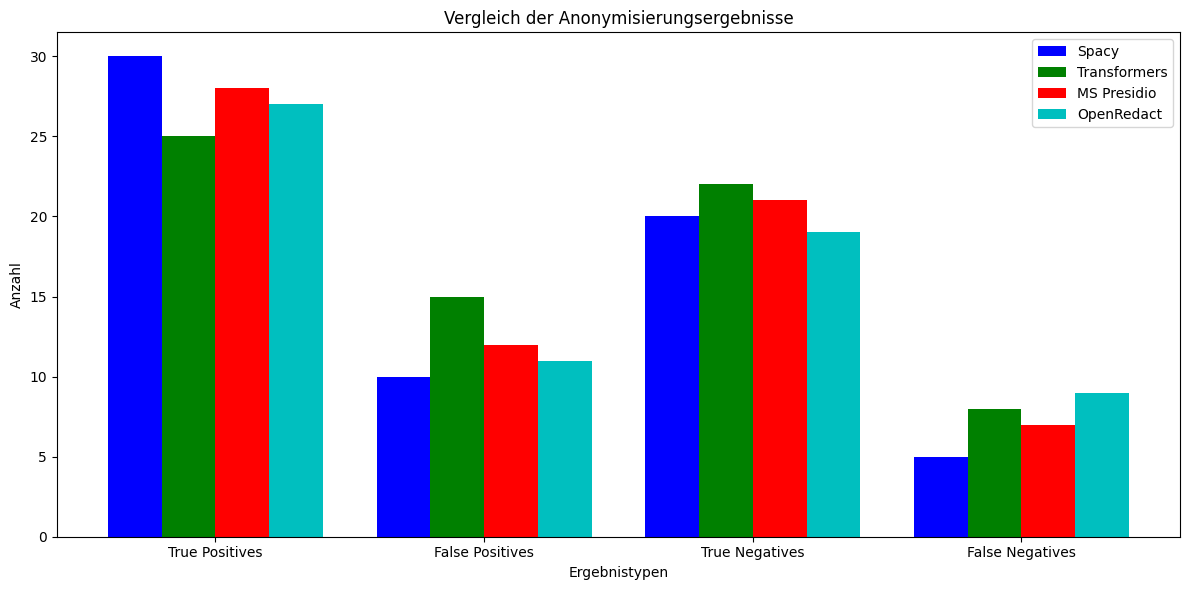

In [282]:
import matplotlib.pyplot as plt

# Beispiel Anonymisierungsergebnisse für True Positives, False Positives, True Negatives, False Negatives
results_spacy = {"True Positives": 30, "False Positives": 10, "True Negatives": 20, "False Negatives": 5}
results_transformers = {"True Positives": 25, "False Positives": 15, "True Negatives": 22, "False Negatives": 8}
results_presidio = {"True Positives": 28, "False Positives": 12, "True Negatives": 21, "False Negatives": 7}
results_openredact = {"True Positives": 27, "False Positives": 11, "True Negatives": 19, "False Negatives": 9}

# Vergleich der Anonymisierungsergebnisse
result_types = list(results_spacy.keys())
values_spacy = list(results_spacy.values())
values_transformers = list(results_transformers.values())
values_presidio = list(results_presidio.values())
values_openredact = list(results_openredact.values())

# Visualisierung der Ergebnisse in einem Balkendiagramm
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = range(len(result_types))

plt.bar(index, values_spacy, bar_width, label='Spacy', color='b')
plt.bar([i + bar_width for i in index], values_transformers, bar_width, label='Transformers', color='g')
plt.bar([i + 2*bar_width for i in index], values_presidio, bar_width, label='MS Presidio', color='r')
plt.bar([i + 3*bar_width for i in index], values_openredact, bar_width, label='OpenRedact', color='c')

plt.xlabel('Ergebnistypen')
plt.ylabel('Anzahl')
plt.title('Vergleich der Anonymisierungsergebnisse')
plt.xticks([i + 1.5*bar_width for i in index], result_types)
plt.legend()
plt.tight_layout()
plt.show()